--- Завантаження моделей ---
YOLO модель (best.pt) успішно завантажено.
Модель класифікатора (classifier_model.keras) успішно завантажено.
--- Моделі готові ---

--- Початок валідації на 1000 зображеннях ---


Обробка зображень: 100%|████████████████████████████████████████████████████████████| 1000/1000 [02:05<00:00,  7.94it/s]


--- Валідацію завершено ---

--- ЗАГАЛЬНА ТОЧНІСТЬ (НА 1000 ЗРАЗКАХ) ---
Жорстка точність (Perfect Match): 92.50%
М'яка точність (Посимвольна): 97.81%

--- Візуалізація прикладів (сітка 5x5) ---


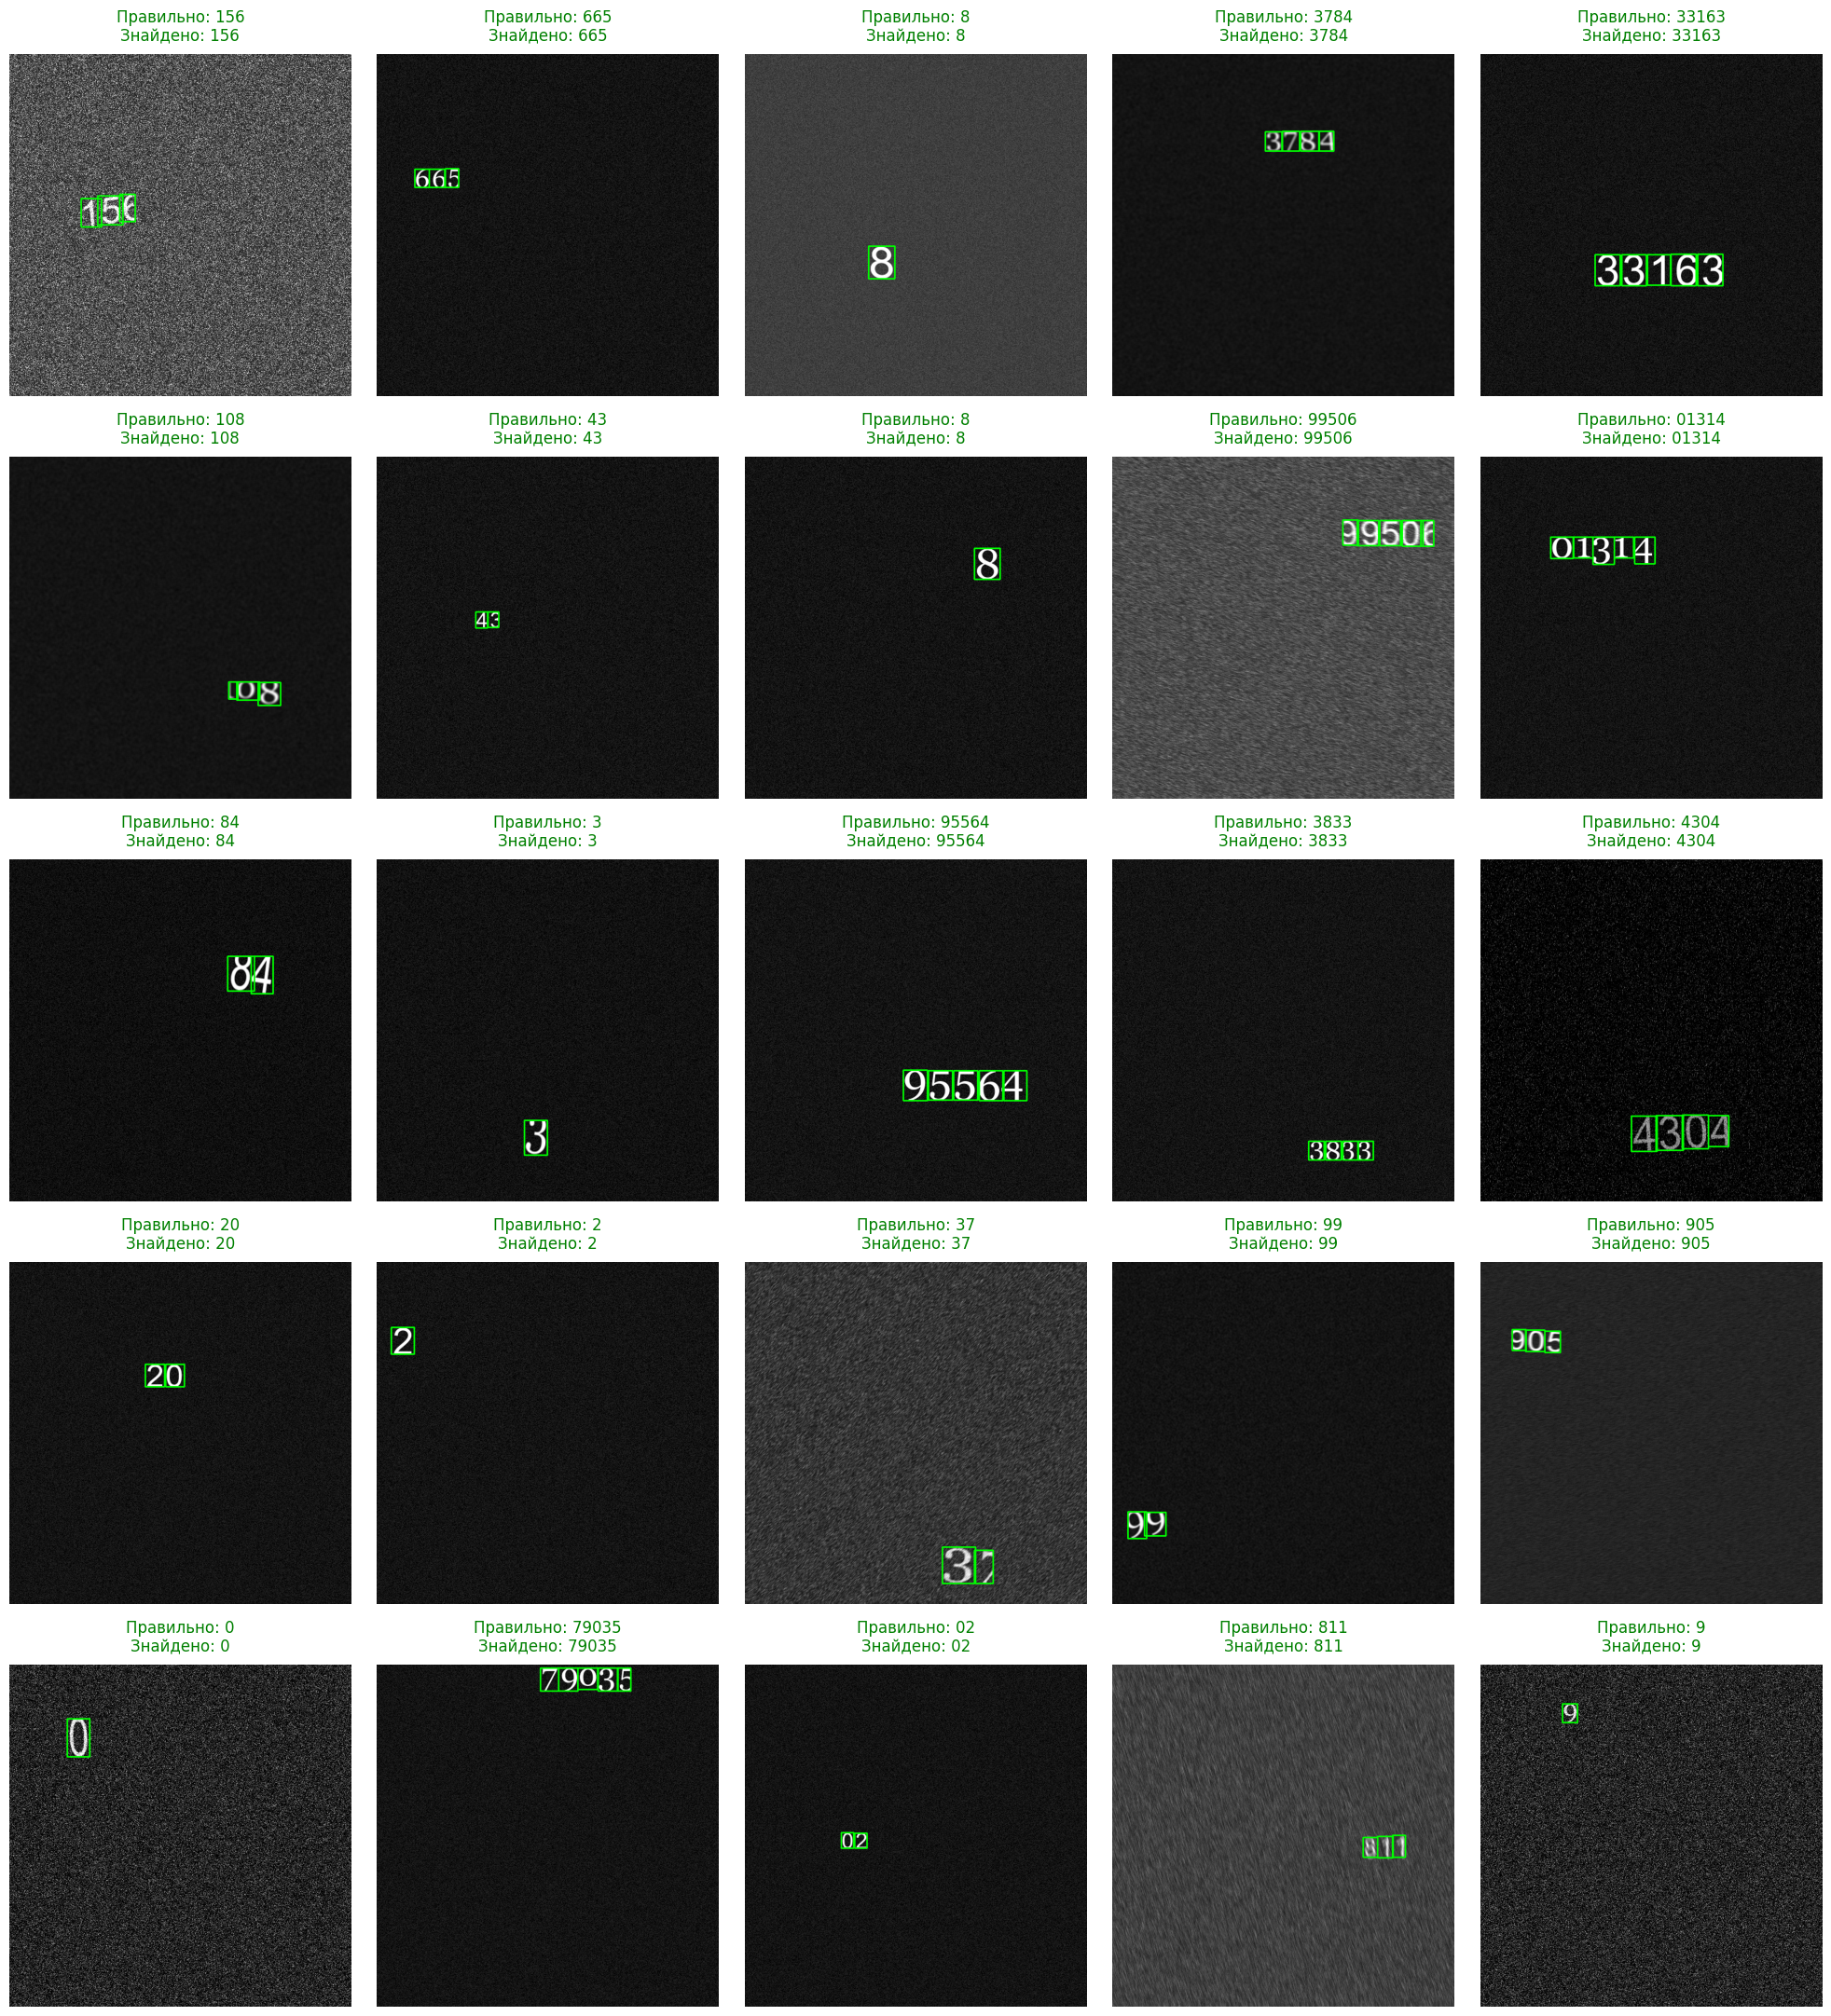

In [5]:
import os
import random
import cv2
import numpy as np
from ultralytics import YOLO
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ---------------------------------
# 1. КОНФІГУРАЦІЯ (ОНОВЛЕНО)
# ---------------------------------

YOLO_MODEL_PATH = 'runs/detect/yolo_single_class_run4/weights/best.pt'
CLASSIFIER_MODEL_PATH = 'learning/classifier_model.keras'

TEST_IMG_DIR = 'learning/final_test_set/images/'
TEST_LBL_DIR = 'learning/final_test_set/labels/'

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!! ЗМІНА: Тепер перевіряємо 1000 !!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
NUM_TEST_IMAGES = 1000
IMAGE_SIZE_CLASSIFIER = (64, 64)

print("--- Завантаження моделей ---")
yolo_model = YOLO(YOLO_MODEL_PATH)
print("YOLO модель (best.pt) успішно завантажено.")
classifier_model = load_model(CLASSIFIER_MODEL_PATH, compile=False)
print("Модель класифікатора (classifier_model.keras) успішно завантажено.")
print("--- Моделі готові ---")


# ---------------------------------
# 2. ДОПОМІЖНІ ФУНКЦІЇ (ДОДАНО НОВУ)
# ---------------------------------

def preprocess_for_classifier(image_crop_gray, target_size=(64, 64)):
    h, w = image_crop_gray.shape[:2]
    if h == 0 or w == 0: return None
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)
    if new_h <= 0 or new_w <= 0: return None
    resized_img = cv2.resize(image_crop_gray, (new_w, new_h), interpolation=cv2.INTER_AREA)
    delta_w, delta_h = target_size[1] - new_w, target_size[0] - new_h
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)
    final_canvas = cv2.copyMakeBorder(resized_img, top, bottom, left, right,
                                     cv2.BORDER_CONSTANT, value=[0])
    return final_canvas.reshape(target_size[0], target_size[1], 1)

def get_ground_truth_number(lbl_path):
    if not os.path.exists(lbl_path): return ""
    try:
        with open(lbl_path, 'r') as f:
            number_str = f.read().strip()
        return number_str
    except Exception: return ""

def run_pipeline_on_image(img_path):
    img_bgr = cv2.imread(img_path)
    if img_bgr is None: return "", None
    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    yolo_results = yolo_model(img_bgr, verbose=False, iou=0.45)
    boxes = yolo_results[0].boxes.cpu().numpy()
    img_with_boxes = img_bgr.copy()
    if len(boxes) == 0: return "", img_with_boxes

    sorted_boxes = sorted(boxes, key=lambda box: box.xyxy[0][0])

    digit_batch, coordinates = [], []
    for box in sorted_boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        processed_digit = preprocess_for_classifier(img_gray[y1:y2, x1:x2], IMAGE_SIZE_CLASSIFIER)
        if processed_digit is not None:
            digit_batch.append(processed_digit)
            coordinates.append((x1, y1, x2, y2))

    if not digit_batch: return "", img_with_boxes

    batch_np = np.array(digit_batch)
    predictions = classifier_model.predict(batch_np, verbose=False)
    predicted_digits = np.argmax(predictions, axis=1)

    final_number_str = ""
    for i, digit in enumerate(predicted_digits):
        final_number_str += str(digit)
        x1, y1, x2, y2 = coordinates[i]
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), (0, 255, 0), 2)

    return final_number_str, img_with_boxes

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!! НОВА ФУНКЦІЯ ДЛЯ "М'ЯКОЇ" ОЦІНКИ !!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def calculate_char_accuracy(s1, s2):
    """
    Розраховує "м'яку" точність (посимвольно)
    Використовує відстань Левенштейна.
    """
    m, n = len(s1), len(s2)
    if m == 0 and n == 0: return 1.0 # Обидва порожні = 100%
    if m == 0 or n == 0: return 0.0 # Один порожній = 0%

    # Ініціалізація матриці
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(m + 1): dp[i][0] = i
    for j in range(n + 1): dp[0][j] = j

    # Розрахунок
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if s1[i - 1] == s2[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1,      # Видалення
                           dp[i][j - 1] + 1,      # Вставка
                           dp[i - 1][j - 1] + cost) # Заміна

    lev_distance = dp[m][n]
    max_len = max(m, n)
    accuracy = (max_len - lev_distance) / max_len
    return accuracy

# ---------------------------------
# 3. ОСНОВНИЙ ЦИКЛ ВАЛІДАЦІЇ (ОНОВЛЕНО)
# ---------------------------------

print(f"\n--- Початок валідації на {NUM_TEST_IMAGES} зображеннях ---")

all_test_images = [f for f in os.listdir(TEST_IMG_DIR) if f.endswith(('.png', '.jpg'))]
random.shuffle(all_test_images)

# Беремо 1000 (або менше, якщо їх не вистачає)
test_sample = all_test_images[:NUM_TEST_IMAGES]

images_for_plot = []
total_hard_correct = 0 # "Жорсткий" підрахунок
total_soft_accuracy = 0.0 # Сума "м'якої" точності
total_count = 0

for img_name in tqdm(test_sample, desc="Обробка зображень"):
    img_path = os.path.join(TEST_IMG_DIR, img_name)
    lbl_name = os.path.splitext(img_name)[0] + '.txt'
    lbl_path = os.path.join(TEST_LBL_DIR, lbl_name)

    correct_number = get_ground_truth_number(lbl_path)
    predicted_number, img_to_plot = run_pipeline_on_image(img_path)

    if correct_number == "":
        continue

    # 1. "Жорсткий" підрахунок
    if correct_number == predicted_number:
        total_hard_correct += 1

    # 2. "М'який" підрахунок
    soft_acc = calculate_char_accuracy(correct_number, predicted_number)
    total_soft_accuracy += soft_acc

    total_count += 1

    if len(images_for_plot) < 25:
        images_for_plot.append((img_to_plot, correct_number, predicted_number))

print("--- Валідацію завершено ---")


# ---------------------------------
# 4. ВИВЕДЕННЯ РЕЗУЛЬТАТІВ (ОНОВЛЕНО)
# ---------------------------------

if total_count > 0:
    hard_accuracy = (total_hard_correct / total_count) * 100
    avg_soft_accuracy = (total_soft_accuracy / total_count) * 100

    print(f"\n--- ЗАГАЛЬНА ТОЧНІСТЬ (НА {total_count} ЗРАЗКАХ) ---")
    print(f"Жорстка точність (Perfect Match): {hard_accuracy:.2f}%")
    print(f"М'яка точність (Посимвольна): {avg_soft_accuracy:.2f}%")
else:
    print("Не вдалося обробити жодного зображення.")

# --- 4.2. Сітка зображень ---
print("\n--- Візуалізація прикладів (сітка 5x5) ---")

fig, axes = plt.subplots(5, 5, figsize=(20, 22))
axes = axes.flatten()

for i, (img, correct, pred) in enumerate(images_for_plot):
    ax = axes[i]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)

    title = f"Правильно: {correct}\nЗнайдено: {pred}"
    color = 'green' if correct == pred else 'red'
    ax.set_title(title, color=color, fontsize=12, pad=10)
    ax.axis('off')

for i in range(len(images_for_plot), len(axes)):
    axes[i].axis('off')

plt.tight_layout(pad=2.0)
plt.show()